In [3]:
#export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import os
import json
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import warnings

In [4]:
#export
np.random.seed(42)
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", None)

In [5]:
directory = Path("/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/")

In [6]:
list(directory.iterdir())

[PosixPath('/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/test_images'),
 PosixPath('/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/label_num_to_disease_map.json'),
 PosixPath('/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/test_tfrecords'),
 PosixPath('/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_tfrecords'),
 PosixPath('/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train.csv'),
 PosixPath('/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images'),
 PosixPath('/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/sample_submission.csv')]

In [7]:
with open(directory/"label_num_to_disease_map.json") as jfile:
    label_map = json.loads(jfile.read())
    
    
label_map

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [8]:
keys = list(label_map.keys())
keys = [int(k) for k in keys]
vals = list(label_map.values())

label_map = {keys[i]:vals[i] for i in range(len(keys))}
label_map

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [9]:
train_dir = directory/"train_images"
test_dir  = directory/"test_images"
train_csv_path = directory/"train.csv"
sample_submission = directory/"sample_submission.csv"

In [10]:
df = pd.read_csv(train_csv_path)
df["class_name"] = [label_map[df["label"][i]] for i in range(len(df))]
df.head()

,image_id,label,class_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


In [11]:
sample_submission = pd.read_csv(sample_submission)
sample_submission.head()

,image_id,label
0,2216849948.jpg,4


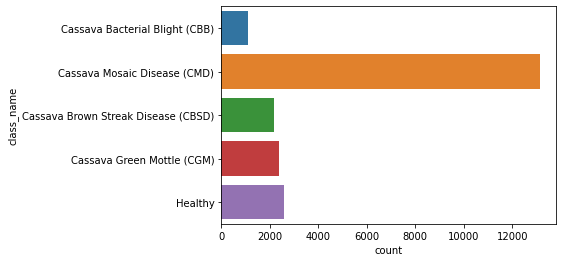

In [12]:
sns.countplot(data=df, y="class_name");

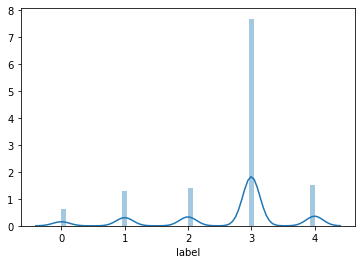

In [13]:
sns.distplot(df.label);

Class Imbalance Present : majority of images belong to the 'Cassava Mosaic Disease (CMD)' or class 3 .

In [14]:
trn_im_paths = list(train_dir.iterdir())
trn_im_paths[:5]

[PosixPath('/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/1900920171.jpg'),
 PosixPath('/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/1695222952.jpg'),
 PosixPath('/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/1492381879.jpg'),
 PosixPath('/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/1046703257.jpg'),
 PosixPath('/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/3968083899.jpg')]

View some sample images from training data :

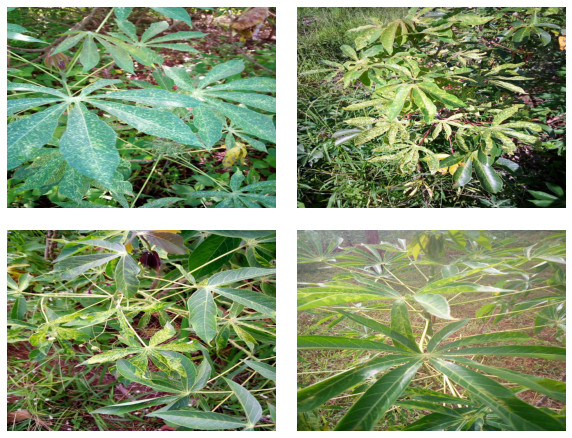

In [15]:
sample_images = trn_im_paths[:4]
sample_images = [Image.open(ps) for ps in sample_images]

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.3)


for ax, im in zip(grid, sample_images):
    ax.imshow(im)
    ax.axis("off")

Generate cross-validation folds :

In [16]:
# shuffle the dataframe
df_shuffled = df.sample(frac=1).reset_index(drop=True)

#instantiate stratified kfold
skf = StratifiedKFold(n_splits=5, random_state=42)

#grab the targets
df_shuffled["kfold"] = -1

#create cross-validation folds
targets = df_shuffled.label.values
for fold, (train_idx, val_idx) in enumerate(skf.split(df_shuffled, targets)):
        df_shuffled.loc[val_idx, 'kfold'] = fold

In [17]:
df_shuffled.head()

,image_id,label,class_name,kfold
0,2615227158.jpg,4,Healthy,0
1,1277648239.jpg,3,Cassava Mosaic Disease (CMD),0
2,2305895487.jpg,3,Cassava Mosaic Disease (CMD),0
3,336299725.jpg,2,Cassava Green Mottle (CGM),0
4,1951270318.jpg,2,Cassava Green Mottle (CGM),0


In [18]:
#getting a particular fold
fold_num = 1
trn_fold_1 = df_shuffled.loc[df_shuffled.kfold==1]
val_fold_1 = df_shuffled.loc[df_shuffled.kfold!=1]

In [19]:
trn_fold_1.kfold.unique(), val_fold_1.kfold.unique()

(array([1]), array([0, 2, 3, 4]))

Putting it all together :

In [20]:
#export
class Preprocessor:
    def __init__(self, csv_path:str, json_path:str, image_dir:str, num_folds:int = 5):
        # read in the pandas dataframe
        dataframe = pd.read_csv(csv_path)
        dataframe["filePath"] = [
            os.path.join(image_dir, dataframe.image_id[i]) for i in range(len(dataframe))
        ]
        
        dataframe["kfold"] = -1
        
        self.dataframe = dataframe
        
        # read in the label map
        label_map = self._read_label_map(json_path)
        keys = list(label_map.keys())
        keys = [int(k) for k in keys]
        vals = list(label_map.values())
        self.label_map = {keys[i]:vals[i] for i in range(len(keys))}
        
        #instantiate stratified kfold
        self.num_folds = num_folds
        self.skf = StratifiedKFold(n_splits=self.num_folds, random_state=42)
        
        # weights for class imbalance
        self.weights = self._get_weights(self.dataframe)
        
    def _get_weights(self, df):
        "weights for class imbalance"
        weights = {}
        for i in range(5):
            # sample size / (num classes * class frequency)
            weights[i] = len(df)/( 5 * len(df.loc[df.label == i]))
        return weights
        
    def _read_label_map(self, json_path):
        with open(json_path) as jfile:
            label_map = json.loads(jfile.read())
        return label_map
    
    def _shuffle_and_create_folds(self, shuffle = True):
        # shuffle the dataframe
        if shuffle:
            _df = self.dataframe.sample(frac=1).reset_index(drop=True)
        else:
            _df = self.dataframe
        
        #grab the targets
        _targets = _df.label.values
        #create cross-validation folds
        for _fold, (train_idx, val_idx) in enumerate(self.skf.split(_df, _targets)):
            _df.loc[val_idx, 'kfold'] = _fold
        
        # replace the original dataframe
        self.dataframe = _df
        
    def get_fold(self, fold_num:int):
        assert fold_num <= self.num_folds
        _train_fold = self.dataframe.loc[self.dataframe.kfold != fold_num]
        _val_fold   = self.dataframe.loc[self.dataframe.kfold == fold_num]
        return _train_fold, _val_fold

In [21]:
train_csv = "/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train.csv"
image_dir = "/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/"
json_dir = "/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/label_num_to_disease_map.json"

processor = Preprocessor(
    csv_path=train_csv, 
    json_path=json_dir, 
    image_dir=image_dir,
    num_folds=5,
)

processor.dataframe.head()


,image_id,label,filePath,kfold
0,1000015157.jpg,0,/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/1000015157.jpg,-1
1,1000201771.jpg,3,/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/1000201771.jpg,-1
2,100042118.jpg,1,/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/100042118.jpg,-1
3,1000723321.jpg,1,/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/1000723321.jpg,-1
4,1000812911.jpg,3,/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/1000812911.jpg,-1


In [22]:
processor.weights

{0: 3.9368905243790246,
 1: 1.954956601187757,
 2: 1.7935456831517183,
 3: 0.3252317981456148,
 4: 1.6606131160263873}

In [23]:
processor.label_map

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [24]:
processor._shuffle_and_create_folds(shuffle=True)
processor.dataframe.head()

,image_id,label,filePath,kfold
0,4052176327.jpg,4,/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/4052176327.jpg,0
1,996762577.jpg,3,/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/996762577.jpg,0
2,434025087.jpg,3,/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/434025087.jpg,0
3,3540765435.jpg,3,/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/3540765435.jpg,0
4,2455356722.jpg,3,/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/2455356722.jpg,0


In [25]:
processor.dataframe.kfold.unique()

array([0, 1, 2, 3, 4])

In [26]:
train_fold, val_fold = processor.get_fold(fold_num=0)

In [27]:
train_fold.kfold.unique(), val_fold.kfold.unique()

(array([1, 2, 3, 4]), array([0]))

In [28]:
len(train_fold), len(val_fold)

(17117, 4280)

**Torch Utils:**

In [29]:
df = pd.read_csv(train_csv_path)
df["class_name"] = [label_map[df["label"][i]] for i in range(len(df))]
df["filePath"] = [str(train_dir/df.image_id[i]) for i in range(len(df))] 
df.head()

,image_id,label,class_name,filePath
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB),/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/1000015157.jpg
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD),/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/1000201771.jpg
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD),/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/100042118.jpg
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD),/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/1000723321.jpg
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD),/Users/ayushman/Desktop/Datasets/cassava-leaf-disease-classification/train_images/1000812911.jpg


In [30]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.utils import make_grid

In [31]:
transformations = A.Compose([
    A.Resize(242, 242, always_apply=True),
    A.Normalize(always_apply=True),
    ToTensorV2(always_apply=True),
])

In [32]:
class PlantDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transformations):
        self.df = dataframe
        self.transforms = transformations
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_id = self.df.filePath[idx]
        
        # Read an image with OpenCV
        img = cv2.imread(image_id)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # apply transformations to the image
        img = self.transforms(image=img)["image"]
        
        target = self.df.label[idx]
        target = torch.tensor(target)
        
        return img, target

In [33]:
ds = PlantDataset(df, transformations)
dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=4)

batch = next(iter(dl))
images, targs = batch

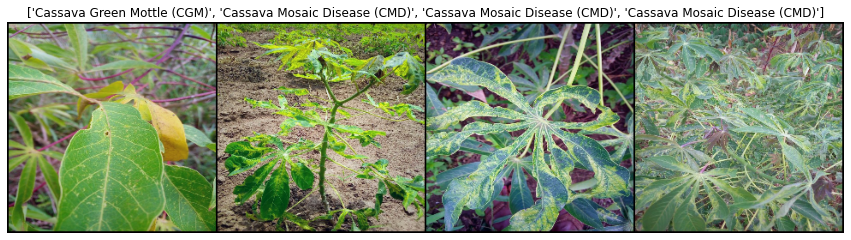

In [34]:
grid = make_grid(images, normalize=True, nrow=4).permute(1, 2, 0).data.numpy()
grid = np.array(grid * 255., dtype=np.uint)
classes = targs.data.numpy()

plt.figure(figsize=(15, 10))
plt.axis("off")
plt.imshow(grid)
plt.title([label_map[i] for i in classes]);

In [35]:
from datasets import PlantDataset

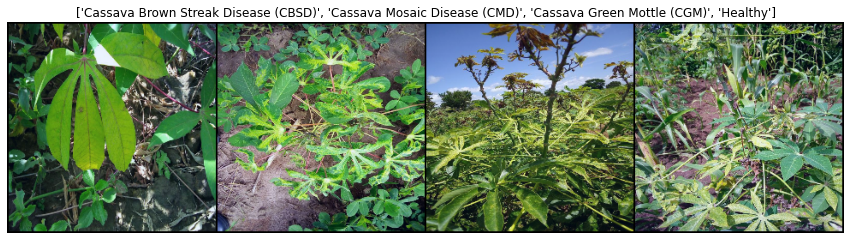

In [36]:
ds = PlantDataset(df, transformations)
dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=4)

batch = next(iter(dl))
images, targs = batch

grid = make_grid(images, normalize=True, nrow=4).permute(1, 2, 0).data.numpy()
grid = np.array(grid * 255., dtype=np.uint)
classes = targs.data.numpy()

plt.figure(figsize=(15, 10))
plt.axis("off")
plt.imshow(grid)
plt.title([label_map[i] for i in classes]);